In [1]:
#Import statements
import numpy as np
import os
import random
import tarfile
import pickle
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from sklearn.model_selection import train_test_split
import torch.nn as nn


from collections import Counter
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float32)
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
#Labels
clabels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship','truck'
]

In [4]:
#Load batch
def load_batch(fname):
    with open(fname, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
        X = dict[b'data']
        Y = dict[b'labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

#Load data
def load_data(dir):
    X_train = []
    y_train = []
    for i in range(1, 6):
        X, Y = load_batch(os.path.join(dir, 'data_batch_' + str(i)))
        X_train.append(X)
        y_train.append(Y)
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train)
    
    X_test, y_test = load_batch(os.path.join(dir, 'test_batch'))

    return X_train, y_train, X_test, y_test

#Extract form tar
def extract_file(file_path, extract_to='.'):
    if file_path.endswith("tar.gz"):
        with tarfile.open(file_path) as tar:
            tar.extractall(path=extract_to)
            print(f"Extracted {file_path} to {extract_to}")

In [5]:
#Splitting for train and val
def split_tv(X_train, y_train, vsize=0.2):
    X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, test_size=vsize, random_state=42, stratify=y_train)
    return X_train2, X_val, y_train2, y_val

cifar10_path = 'cifar-10-python.tar.gz'
dir = 'cifar-10-batches-py'  

extract_file(cifar10_path, extract_to='.')

X_train, y_train, X_test, y_test = load_data(dir)


X_train, X_val, y_train, y_val = split_tv(X_train, y_train, vsize=0.2)

#Shapes
print(f"Train data: {X_train.shape}")
print(f"Train labels: {y_train.shape}")
print(f"Val data: {X_val.shape}")
print(f"Val labels: {y_val.shape}")
print(f"Test data: {X_test.shape}")
print(f"Test labels: {y_test.shape}")

Extracted cifar-10-python.tar.gz to .
Train data: (40000, 32, 32, 3)
Train labels: (40000,)
Val data: (10000, 32, 32, 3)
Val labels: (10000,)
Test data: (10000, 32, 32, 3)
Test labels: (10000,)


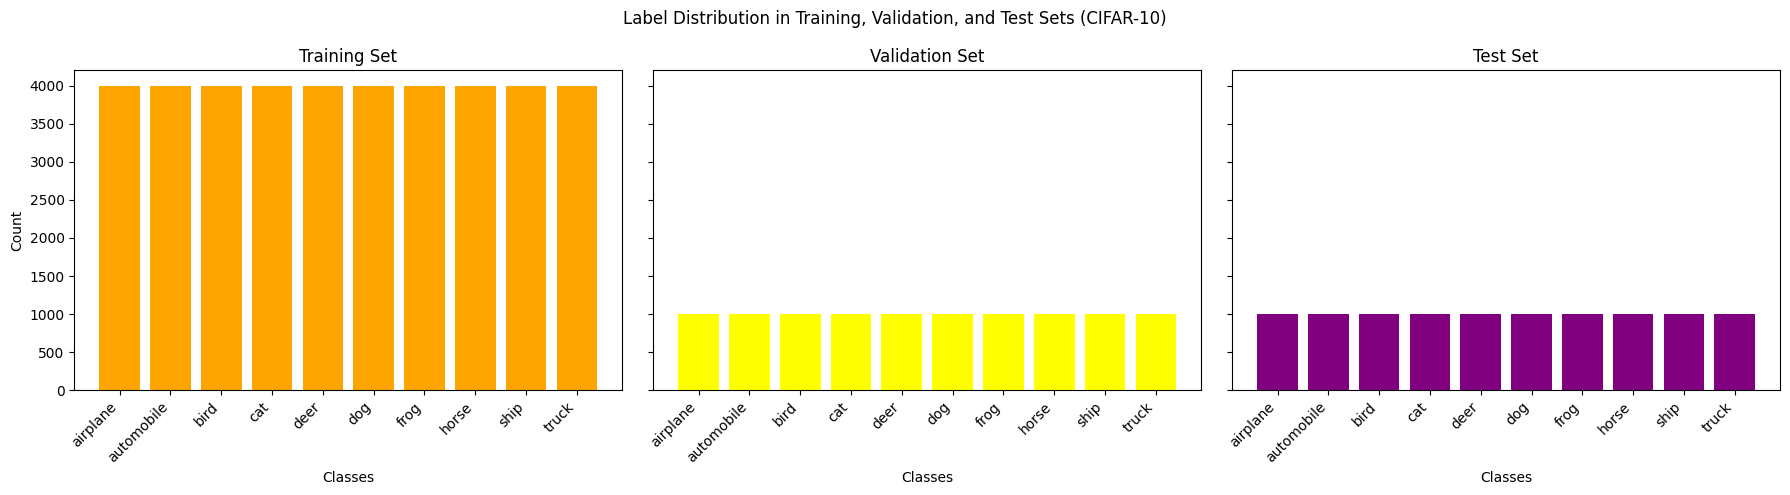

In [6]:
#Labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

#Counting occurrences
trainc = Counter(y_train)
testc = Counter(y_test)
valc = Counter(y_val)

train_label_c = [trainc.get(label, 0) for label in range(10)]
val_label_c = [valc.get(label, 0) for label in range(10)]
test_label_c = [testc.get(label, 0) for label in range(10)]

#Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
fig.suptitle("Label Distribution in Training, Validation, and Test Sets (CIFAR-10)")

#Training
axes[0].bar(class_names, train_label_c, color='orange')
axes[0].set_title("Training Set")
axes[0].set_xlabel("Classes")
axes[0].set_ylabel("Count")

#Val
axes[1].bar(class_names, val_label_c, color='yellow')
axes[1].set_title("Validation Set")
axes[1].set_xlabel("Classes")

#Test
axes[2].bar(class_names, test_label_c, color='purple')
axes[2].set_title("Test Set")
axes[2].set_xlabel("Classes")

for ax in axes:
    ax.set_xticklabels(class_names, rotation=45, ha='right')

plt.tight_layout()
plt.show()


In [7]:
trans_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  
])

trans_train = transforms.Compose([
    
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  
])

In [8]:

class new_data():
    def __init__(self,X, y, transform = None ):
        self.X = X
        self.y = y 
        self.transform = transform
    def __len__(self):
        return len(self.y)
    def __getitem__(self,idx):
        image = self.X[idx].astype(np.uint8)
        label = self.y[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_data = new_data(X_train, y_train, transform=trans_train)
test_data = new_data(X_test, y_test, transform=trans_val)
val_data = new_data(X_val,y_val, transform = trans_val )

trainloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
testloader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)
valloader = DataLoader(val_data, batch_size=64, shuffle=False,num_workers=0)

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [10]:
#Labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


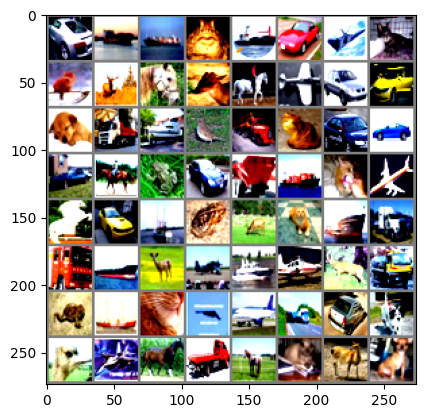

In [11]:
#Citing code pytorch.org
def Display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
Display(torchvision.utils.make_grid(images))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6796272..1.8768656].


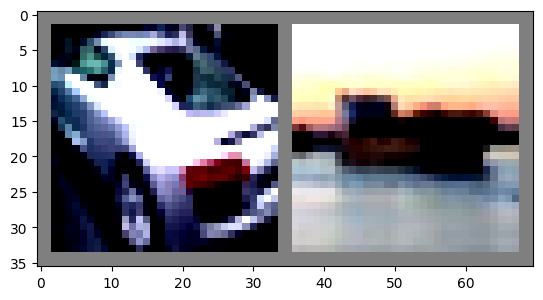

Sampled labels: [1, 8]


In [12]:
sampled_images = images[:2]
sampled_labels = labels[:2]

Display(torchvision.utils.make_grid(sampled_images))
print("Sampled labels:", sampled_labels.tolist())

In [13]:
def plot_learning_curves(epochs, train_acc, train_loss, val_acc, val_loss):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Loss
    ax[0].plot(range(1, epochs + 1), train_loss, label='Training Loss')
    ax[0].plot(range(1, epochs + 1), val_loss, label='Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[0].set_title('Training and Validation Loss')

    # Accuracy
    ax[1].plot(range(1, epochs + 1), train_acc, label='Training Accuracy')
    ax[1].plot(range(1, epochs + 1), val_acc, label='Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy (%)')
    ax[1].legend()
    ax[1].set_title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.show()


# Baseline function

In [16]:
import torch

def train_and_validate(model, trainloader, valloader, loss_fn, optimizer, device, num_epochs=20, patience=5):
   
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    # Early stopping and model saving variables
    best_validation_loss = float('inf')
    pc = 0  
    best_model_state = None  
    completed_epochs = 0 

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0.0
        train_correct_predictions = 0
        train_actuals = 0

        for data in trainloader:
            ip, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            op = model(ip)
            loss = loss_fn(op, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(op, 1)
            train_actuals += labels.size(0)
            train_correct_predictions += (predicted == labels).sum().item()

        train_loss = total_train_loss / len(trainloader)
        train_accuracy = 100 * train_correct_predictions / train_actuals
        training_losses.append(train_loss)
        training_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        correct_validation_predictions = 0
        val_actuals = 0

        with torch.no_grad():
            for data in valloader:
                ip, labels = data[0].to(device), data[1].to(device)
                op = model(ip)
                loss = loss_fn(op, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(op, 1)
                val_actuals += labels.size(0)
                correct_validation_predictions += (predicted == labels).sum().item()

        total_val_loss /= len(valloader)
        val_accuracy = 100 * correct_validation_predictions / val_actuals
        validation_losses.append(total_val_loss)
        validation_accuracies.append(val_accuracy)

        # Print statistics
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {total_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Early stopping logic and in-memory model saving
        if total_val_loss < best_validation_loss:
            best_validation_loss = total_val_loss
            pc = 0
            best_model_state = model.state_dict()  # Save the best model's state in memory
        else:
            pc += 1

        if pc >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        completed_epochs += 1  # Increment actual completed epoch count

    # Load the best model state before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print('Finished Training')
    
    # Return the best model along with the training/validation results
    return model, training_losses[:completed_epochs], validation_losses[:completed_epochs], training_accuracies[:completed_epochs], validation_accuracies[:completed_epochs]


# ResNet Baseline

In [17]:
epochs = 20

resnet = models.resnet18(pretrained=False)
resnet.fc = nn.Linear(resnet.fc.in_features, 10) 
resnet = resnet.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01)

# Train and validate
model, train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate(
    model=resnet, 
    trainloader=trainloader, 
    valloader=valloader, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    device=device,
    num_epochs=epochs, 
    patience=5
)

Epoch [1/20], Train Loss: 1.6285, Train Accuracy: 40.52%, Val Loss: 1.4001, Val Accuracy: 49.56%
Epoch [2/20], Train Loss: 1.3145, Train Accuracy: 52.60%, Val Loss: 1.2528, Val Accuracy: 55.07%
Epoch [3/20], Train Loss: 1.1535, Train Accuracy: 58.76%, Val Loss: 1.1514, Val Accuracy: 59.23%
Epoch [4/20], Train Loss: 1.0331, Train Accuracy: 63.24%, Val Loss: 1.0783, Val Accuracy: 62.28%
Epoch [5/20], Train Loss: 0.9372, Train Accuracy: 67.25%, Val Loss: 1.0432, Val Accuracy: 63.52%
Epoch [6/20], Train Loss: 0.8478, Train Accuracy: 70.02%, Val Loss: 1.0320, Val Accuracy: 64.66%
Epoch [7/20], Train Loss: 0.7845, Train Accuracy: 72.63%, Val Loss: 0.9934, Val Accuracy: 65.87%
Epoch [8/20], Train Loss: 0.7062, Train Accuracy: 75.21%, Val Loss: 1.0016, Val Accuracy: 65.95%
Epoch [9/20], Train Loss: 0.6454, Train Accuracy: 77.24%, Val Loss: 0.9904, Val Accuracy: 67.20%
Epoch [10/20], Train Loss: 0.5908, Train Accuracy: 79.36%, Val Loss: 1.0162, Val Accuracy: 66.67%
Epoch [11/20], Train Loss: 0.

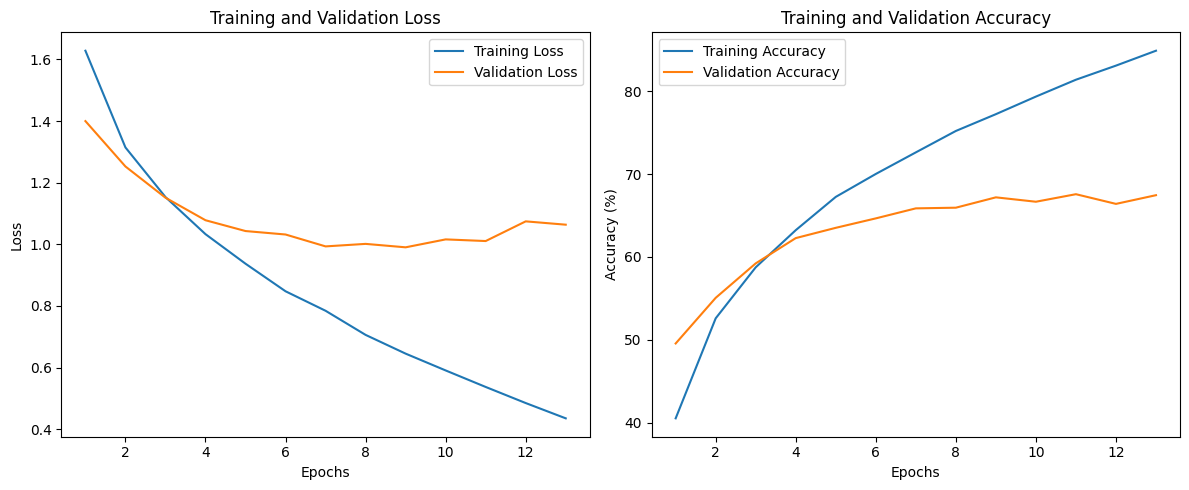

In [18]:
#Plotting
plot_learning_curves(len(train_accuracies), train_accuracies, train_losses, val_accuracies,val_losses)

# ResNet Finetuning

In [19]:
import torch

def train_and_validate_ft(model, trainloader, valloader, loss_fn, optimizer, device, num_epochs=20, patience=5, scheduler=None): 
    # Initialize lists to store loss and accuracy values for plotting
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []
    best_validation_loss = float('inf')
    pc = 0  
    best_model_state = None  
    completed_epochs = 0  

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0.0
        train_correct_predictions = 0
        train_actuals = 0

        for data in trainloader:
            ip, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            op = model(ip)
            loss = loss_fn(op, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(op, 1)
            train_actuals += labels.size(0)
            train_correct_predictions += (predicted == labels).sum().item()

        train_loss = total_train_loss / len(trainloader)
        train_accuracy = 100 * train_correct_predictions / train_actuals
        training_losses.append(train_loss)
        training_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        correct_validation_predictions = 0
        val_actuals = 0

        with torch.no_grad():
            for data in valloader:
                ip, labels = data[0].to(device), data[1].to(device)
                op = model(ip)
                loss = loss_fn(op, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(op, 1)
                val_actuals += labels.size(0)
                correct_validation_predictions += (predicted == labels).sum().item()

        total_val_loss /= len(valloader)
        val_accuracy = 100 * correct_validation_predictions / val_actuals
        validation_losses.append(total_val_loss)
        validation_accuracies.append(val_accuracy)

        # Print statistics
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {total_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        # Early stopping logic and in-memory model saving
        if total_val_loss < best_validation_loss:
            best_validation_loss = total_val_loss
            pc = 0  # Reset count if validation improves
            best_model_state = model.state_dict()  # Save the best model's state in memory
        else:
            pc += 1

        if pc >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

        # Step the scheduler if provided
        if scheduler:
            scheduler.step()

        completed_epochs += 1  # Increment actual completed epoch count

    # Load the best model state before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print('Finished Training')
    
    # Return the best model along with the training/validation results
    return model, training_losses[:completed_epochs], validation_losses[:completed_epochs], training_accuracies[:completed_epochs], validation_accuracies[:completed_epochs]


In [ ]:
def find_best_config_index(result_list):
    best_index = -1
    best_config = None
    best_val_accuracy = 0.0

    for i, config in enumerate(result_list):

        #Final val accuracy 
        final_val_accuracy = config['val_accuracies'][-1]
        
        #Update best_config and best_index
        if final_val_accuracy > best_val_accuracy:
            best_val_accuracy = final_val_accuracy
            best_config = config
            best_index = i

    return best_index, best_config, best_val_accuracy



In [21]:
def grid_search_train(trainloader, valloader, device, learning_rates, weight_decays, model, num_epochs=20):
    results = []

    for lr in learning_rates:
        for wd in weight_decays:
            
            print(f"Training with lr={lr}, weight_decay={wd}")

          
            model = model.to(device)
            model.apply(lambda m: m.reset_parameters() if hasattr(m, "reset_parameters") else None)

            # Loss_fn and optimizer
            loss_fn = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
            schedulers = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

            # Train and validate
            model, train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate_ft(
                model=model,
                trainloader=trainloader,
                valloader=valloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                num_epochs=num_epochs,
                patience=5,
                scheduler=schedulers
            )

            #Results
            results.append({
                "learning_rate": lr,
                "weight_decay": wd,
                "scheduler": 'step scheduler',
                "train_losses": train_losses,
                "val_losses": val_losses,
                "train_accuracies": train_accuracies,
                "val_accuracies": val_accuracies,
                "model_state_dict": model.state_dict()
            })

            print(f"Finished training with lr={lr}, weight_decay={wd}")
    return results

In [ ]:
#Initialization

learning_rates = [0.001, 0.0001]
weight_decays = [0, 0.0001]
resnet_ft = models.resnet18(pretrained=False)
resnet_ft.fc = nn.Linear(resnet_ft.fc.in_features, 10)
result_resnet18 = grid_search_train(trainloader=trainloader, valloader=valloader, device=device, learning_rates=learning_rates, weight_decays=weight_decays, model =resnet_ft )

Training with lr=0.001, weight_decay=0
Epoch [1/20], Train Loss: 1.4476, Train Accuracy: 47.72%, Val Loss: 1.2467, Val Accuracy: 55.85%
Epoch [2/20], Train Loss: 1.0613, Train Accuracy: 62.59%, Val Loss: 1.0407, Val Accuracy: 63.16%
Epoch [3/20], Train Loss: 0.8852, Train Accuracy: 68.99%, Val Loss: 0.9766, Val Accuracy: 66.30%
Epoch [4/20], Train Loss: 0.7797, Train Accuracy: 72.71%, Val Loss: 0.7930, Val Accuracy: 72.26%
Epoch [5/20], Train Loss: 0.6915, Train Accuracy: 75.86%, Val Loss: 0.7857, Val Accuracy: 72.83%
Epoch [6/20], Train Loss: 0.6312, Train Accuracy: 78.32%, Val Loss: 0.6960, Val Accuracy: 76.35%
Epoch [7/20], Train Loss: 0.5667, Train Accuracy: 80.55%, Val Loss: 0.7076, Val Accuracy: 75.96%
Epoch [8/20], Train Loss: 0.5312, Train Accuracy: 81.76%, Val Loss: 0.6570, Val Accuracy: 77.61%
Epoch [9/20], Train Loss: 0.4740, Train Accuracy: 83.52%, Val Loss: 0.7014, Val Accuracy: 77.09%
Epoch [10/20], Train Loss: 0.4289, Train Accuracy: 85.14%, Val Loss: 0.6332, Val Accurac

Best Configuration Index: 0
Best Configuration:
Learning Rate: 0.001
Weight Decay: 0
Scheduler: step scheduler
Final Validation Accuracy: 78.40%


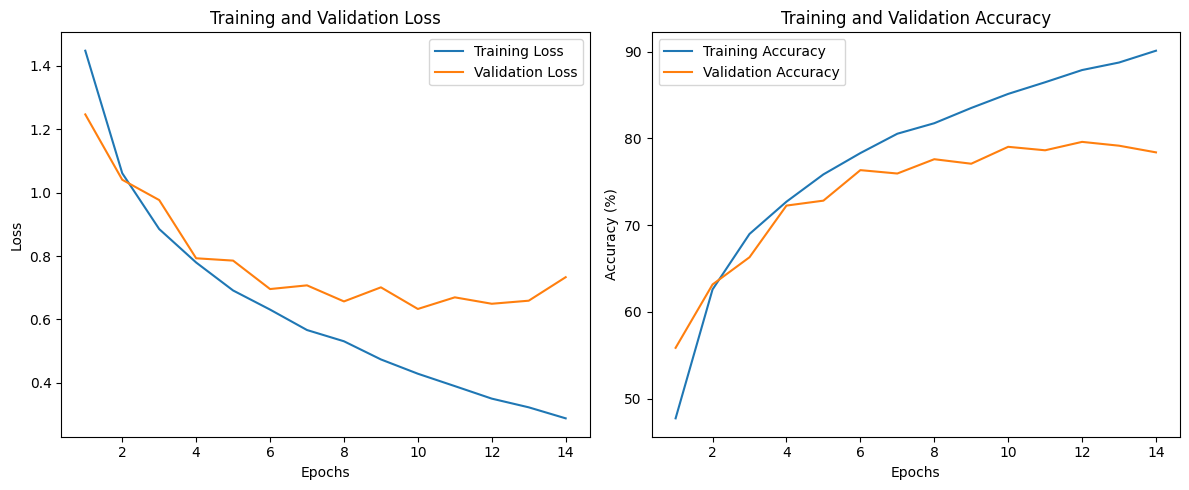

Test Accuracy: 71.54%


In [23]:



best_index, best_config, best_val_accuracy = find_best_config_index(result_resnet18)


print(f"Best Configuration Index: {best_index}")
print("Best Configuration:")
print(f"Learning Rate: {best_config['learning_rate']}")
print(f"Weight Decay: {best_config['weight_decay']}")
print(f"Scheduler: {best_config['scheduler']}")
print(f"Final Validation Accuracy: {best_val_accuracy:.2f}%")

plot_learning_curves(len(result_resnet18[best_index]['train_accuracies']),
                      result_resnet18[best_index]['train_accuracies'],
                        result_resnet18[best_index]['train_losses'],
                          result_resnet18[best_index]['val_accuracies'], 
                          result_resnet18[best_index]['val_losses'])



#Best model 

resnet_model = models.resnet18(pretrained=False)
resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, 10)

resnet_model.load_state_dict(result_resnet18[best_index]['model_state_dict'])
resnet_model = resnet_model.to(device)
resnet_model.eval()

#Evaluate
correct = 0
total = 0

with torch.no_grad():
    for data in testloader: 
        ip, labels = data[0].to(device), data[1].to(device)
        op = resnet_model(ip)
        _, predicted = torch.max(op.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

#Accuracy
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')


# SqueezeNet Baseline

Epoch [1/20], Train Loss: 2.3037, Train Accuracy: 11.32%, Val Loss: 2.2554, Val Accuracy: 14.98%
Epoch [2/20], Train Loss: 2.2330, Train Accuracy: 15.85%, Val Loss: 2.1893, Val Accuracy: 18.75%
Epoch [3/20], Train Loss: 2.1627, Train Accuracy: 19.25%, Val Loss: 2.1075, Val Accuracy: 23.39%
Epoch [4/20], Train Loss: 2.0839, Train Accuracy: 22.55%, Val Loss: 1.9907, Val Accuracy: 26.11%
Epoch [5/20], Train Loss: 2.0032, Train Accuracy: 24.16%, Val Loss: 1.9511, Val Accuracy: 26.63%
Epoch [6/20], Train Loss: 1.9432, Train Accuracy: 26.36%, Val Loss: 1.8658, Val Accuracy: 29.23%
Epoch [7/20], Train Loss: 1.8942, Train Accuracy: 27.89%, Val Loss: 1.8249, Val Accuracy: 31.33%
Epoch [8/20], Train Loss: 1.8522, Train Accuracy: 29.91%, Val Loss: 1.7866, Val Accuracy: 31.86%
Epoch [9/20], Train Loss: 1.8169, Train Accuracy: 31.04%, Val Loss: 1.8275, Val Accuracy: 31.40%
Epoch [10/20], Train Loss: 1.7847, Train Accuracy: 32.95%, Val Loss: 1.7189, Val Accuracy: 35.61%
Epoch [11/20], Train Loss: 1.

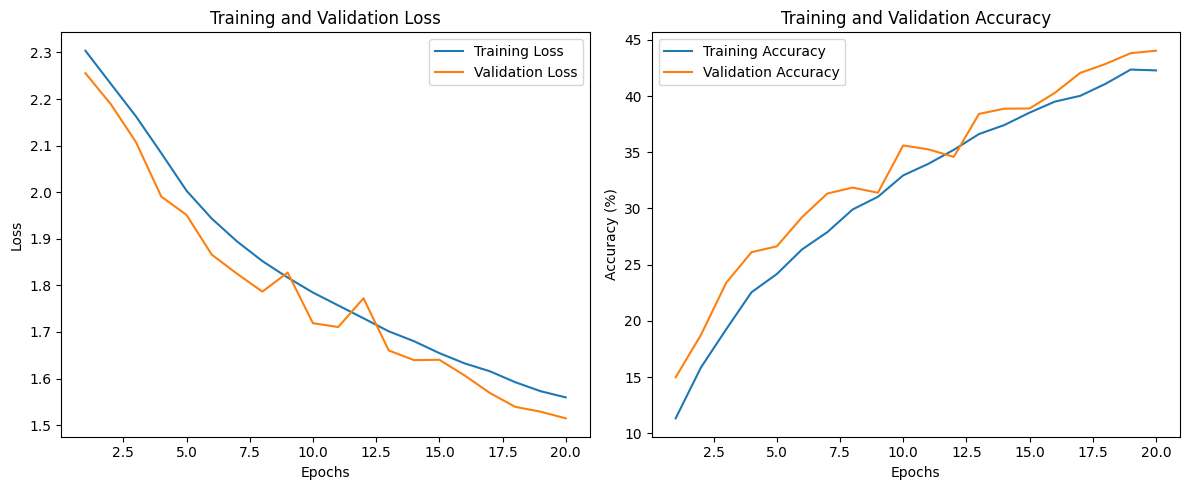

SqueezeNet model saved as 'squeezenet_model.pth'


In [24]:
squeezenet = models.squeezenet1_1(pretrained=False)
squeezenet.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
squeezenet.num_classes = 10
squeezenet = squeezenet.to(device)

#Loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(squeezenet.parameters(), lr=0.001)

# Train and validate
squeezenet_model, train_losses_sq, val_losses_sq, train_accuracies_sq, val_accuracies_sq = train_and_validate(
    model=squeezenet, 
    trainloader=trainloader, 
    valloader=valloader, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    device=device,
    num_epochs=20, 
    patience=5,
)

#Plotting
plot_learning_curves(
    len(train_accuracies_sq), 
    train_accuracies_sq, 
    train_losses_sq, 
    val_accuracies_sq,
    val_losses_sq
)

#Save model
torch.save(squeezenet_model.state_dict(), 'squeezenet_model.pth')
print("SqueezeNet model saved as 'squeezenet_model.pth'")

# SqueezeNet Finetuning with loaded weights

Epoch [1/50], Train Loss: 1.8835, Train Accuracy: 30.65%, Val Loss: 1.6697, Val Accuracy: 38.30%
Epoch [2/50], Train Loss: 1.6757, Train Accuracy: 38.72%, Val Loss: 1.6181, Val Accuracy: 41.19%
Epoch [3/50], Train Loss: 1.5840, Train Accuracy: 41.95%, Val Loss: 1.4640, Val Accuracy: 46.29%
Epoch [4/50], Train Loss: 1.5159, Train Accuracy: 44.95%, Val Loss: 1.4164, Val Accuracy: 47.87%
Epoch [5/50], Train Loss: 1.4633, Train Accuracy: 46.85%, Val Loss: 1.3985, Val Accuracy: 49.02%
Epoch [6/50], Train Loss: 1.4190, Train Accuracy: 48.52%, Val Loss: 1.3757, Val Accuracy: 50.09%
Epoch [7/50], Train Loss: 1.3833, Train Accuracy: 50.15%, Val Loss: 1.3940, Val Accuracy: 50.17%
Epoch [8/50], Train Loss: 1.3416, Train Accuracy: 51.52%, Val Loss: 1.3842, Val Accuracy: 49.87%
Epoch [9/50], Train Loss: 1.3080, Train Accuracy: 53.13%, Val Loss: 1.2809, Val Accuracy: 54.18%
Epoch [10/50], Train Loss: 1.2799, Train Accuracy: 54.23%, Val Loss: 1.2374, Val Accuracy: 55.62%
Epoch [11/50], Train Loss: 1.

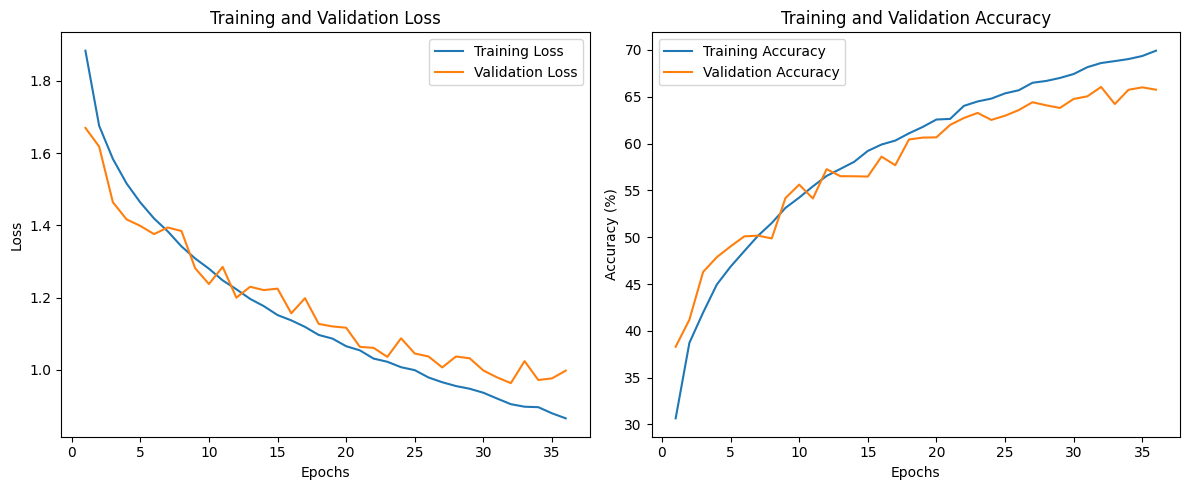

In [25]:
squeezenet = models.squeezenet1_1(pretrained=False)
squeezenet.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
squeezenet.num_classes = 10

#Load pre-trained weights
squeezenet.load_state_dict(torch.load("squeezenet_model.pth"))

squeezenet = squeezenet.to(device)

#Loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(squeezenet.parameters(), lr=0.01)

# Train and validate
squueze_net_ft_2,train_losses_sq_2, val_losses_sq_2, train_accuracies_sq_2, val_accuracies_sq_2 = train_and_validate(
    model=squeezenet, 
    trainloader=trainloader, 
    valloader=valloader, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    device=device,
    num_epochs=50, patience=5
)

#Plotting
plot_learning_curves(len(train_accuracies_sq_2), train_accuracies_sq_2, train_losses_sq_2, val_accuracies_sq_2,val_losses_sq_2)

# SqueezeNet Finetuning with increased epochs

Epoch [1/50], Train Loss: 2.1682, Train Accuracy: 19.75%, Val Loss: 1.9275, Val Accuracy: 28.39%
Epoch [2/50], Train Loss: 1.8733, Train Accuracy: 30.51%, Val Loss: 1.7123, Val Accuracy: 35.66%
Epoch [3/50], Train Loss: 1.7266, Train Accuracy: 36.28%, Val Loss: 1.9003, Val Accuracy: 32.65%
Epoch [4/50], Train Loss: 1.6427, Train Accuracy: 39.88%, Val Loss: 1.5427, Val Accuracy: 43.35%
Epoch [5/50], Train Loss: 1.5718, Train Accuracy: 42.47%, Val Loss: 1.5283, Val Accuracy: 44.24%
Epoch [6/50], Train Loss: 1.5153, Train Accuracy: 44.43%, Val Loss: 1.4696, Val Accuracy: 46.03%
Epoch [7/50], Train Loss: 1.4733, Train Accuracy: 46.67%, Val Loss: 1.4486, Val Accuracy: 47.95%
Epoch [8/50], Train Loss: 1.4298, Train Accuracy: 48.20%, Val Loss: 1.4026, Val Accuracy: 48.98%
Epoch [9/50], Train Loss: 1.4017, Train Accuracy: 49.64%, Val Loss: 1.4470, Val Accuracy: 48.07%
Epoch [10/50], Train Loss: 1.3710, Train Accuracy: 50.56%, Val Loss: 1.3677, Val Accuracy: 50.57%
Epoch [11/50], Train Loss: 1.

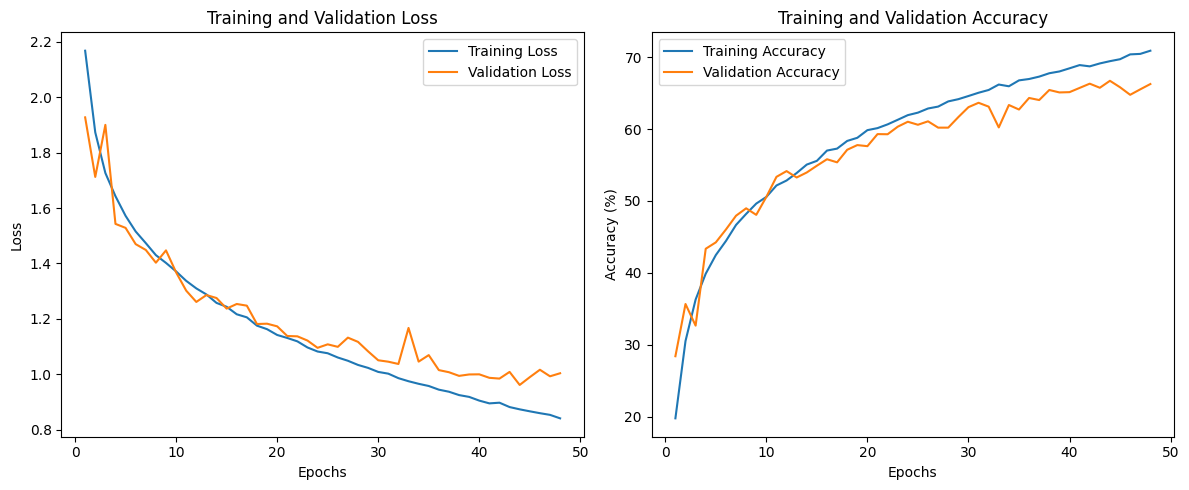

In [ ]:
squeezenet = models.squeezenet1_1(pretrained=False)
squeezenet.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
squeezenet.num_classes = 10


squeezenet = squeezenet.to(device)

#Loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(squeezenet.parameters(), lr=0.01)

# Train and validate
squueze_net_ft_1,train_losses_sq, val_losses_sq, train_accuracies_sq, val_accuracies_sq = train_and_validate(
    model=squeezenet, 
    trainloader=trainloader, 
    valloader=valloader, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    device=device,
    num_epochs=50, patience=5
)

#Plotting
plot_learning_curves(len(train_accuracies_sq), train_accuracies_sq, train_losses_sq, val_accuracies_sq,val_losses_sq)

In [27]:
torch.save(squueze_net_ft_1.state_dict(), 'squeezenet_model_1.pth')
print("SqueezeNet model saved as 'squeezenet_model_1.pth'")

squeezenet = models.squeezenet1_1(pretrained=False)
squeezenet.classifier[1] = nn.Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
squeezenet.num_classes = 10

#Load pre-trained weights
squeezenet.load_state_dict(torch.load("squeezenet_model_1.pth"))

squeezenet = squeezenet.to(device)
squeezenet.eval()

#Evaluate on test
correct = 0
total = 0

with torch.no_grad():
    for data in testloader: 
        ip, labels = data[0].to(device), data[1].to(device)
        op = squeezenet(ip)
        _, predicted = torch.max(op.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

#Accuracy
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

SqueezeNet model saved as 'squeezenet_model_1.pth'
Test Accuracy: 66.54%


# EfficientNet Adam Optimizer

Epoch [1/20], Train Loss: 2.5424, Train Accuracy: 12.01%, Val Loss: 2.3092, Val Accuracy: 10.61%
Epoch [2/20], Train Loss: 2.2149, Train Accuracy: 16.33%, Val Loss: 2.0671, Val Accuracy: 19.20%
Epoch [3/20], Train Loss: 2.1057, Train Accuracy: 18.84%, Val Loss: 2.1426, Val Accuracy: 16.16%
Epoch [4/20], Train Loss: 2.1352, Train Accuracy: 17.30%, Val Loss: 2.0288, Val Accuracy: 19.97%
Epoch [5/20], Train Loss: 2.2404, Train Accuracy: 14.52%, Val Loss: 2.3081, Val Accuracy: 13.83%
Epoch [6/20], Train Loss: 2.2137, Train Accuracy: 15.58%, Val Loss: 2.2078, Val Accuracy: 14.82%
Epoch [7/20], Train Loss: 2.1393, Train Accuracy: 17.44%, Val Loss: 2.0163, Val Accuracy: 21.75%
Epoch [8/20], Train Loss: 2.0200, Train Accuracy: 21.44%, Val Loss: 2.0128, Val Accuracy: 20.58%
Epoch [9/20], Train Loss: 2.0977, Train Accuracy: 19.14%, Val Loss: 1.9964, Val Accuracy: 22.38%
Epoch [10/20], Train Loss: 1.9222, Train Accuracy: 25.06%, Val Loss: 1.9933, Val Accuracy: 24.39%
Epoch [11/20], Train Loss: 1.

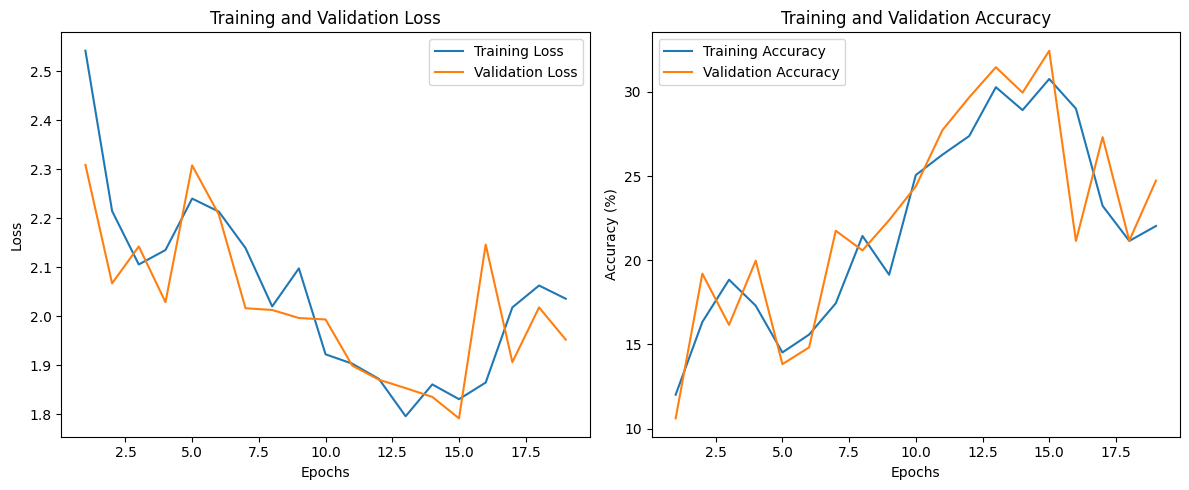

In [28]:
efficientnet_b0 = models.efficientnet_b0(pretrained=False)  
efficientnet_b0.classifier[1] = nn.Linear(efficientnet_b0.classifier[1].in_features, 10)
efficientnet_b0 = efficientnet_b0.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_b0.parameters(), lr=0.01)

ef_net_ad, train_losses_en, val_losses_en, train_accuracies_en, val_accuracies_en = train_and_validate(
    model=efficientnet_b0, 
    trainloader=trainloader, 
    valloader=valloader, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    device=device,
    num_epochs=epochs, patience=5,
)

#Plotting
plot_learning_curves(len(train_accuracies_en), train_accuracies_en, train_losses_en, val_accuracies_en, val_losses_en)

# EfficientNet Baseline

Epoch [1/30], Train Loss: 2.2938, Train Accuracy: 14.34%, Val Loss: 2.3152, Val Accuracy: 15.55%
Epoch [2/30], Train Loss: 2.1807, Train Accuracy: 18.67%, Val Loss: 2.2137, Val Accuracy: 22.13%
Epoch [3/30], Train Loss: 2.0347, Train Accuracy: 23.19%, Val Loss: 2.0664, Val Accuracy: 28.07%
Epoch [4/30], Train Loss: 1.9199, Train Accuracy: 27.44%, Val Loss: 2.0596, Val Accuracy: 32.67%
Epoch [5/30], Train Loss: 1.8349, Train Accuracy: 30.80%, Val Loss: 1.9163, Val Accuracy: 34.61%
Epoch [6/30], Train Loss: 1.7774, Train Accuracy: 32.75%, Val Loss: 1.8897, Val Accuracy: 36.71%
Epoch [7/30], Train Loss: 1.7188, Train Accuracy: 35.61%, Val Loss: 1.7267, Val Accuracy: 38.38%
Epoch [8/30], Train Loss: 1.6834, Train Accuracy: 36.91%, Val Loss: 1.6556, Val Accuracy: 40.17%
Epoch [9/30], Train Loss: 1.6431, Train Accuracy: 38.83%, Val Loss: 1.6054, Val Accuracy: 42.31%
Epoch [10/30], Train Loss: 1.6103, Train Accuracy: 40.18%, Val Loss: 1.5780, Val Accuracy: 43.76%
Epoch [11/30], Train Loss: 1.

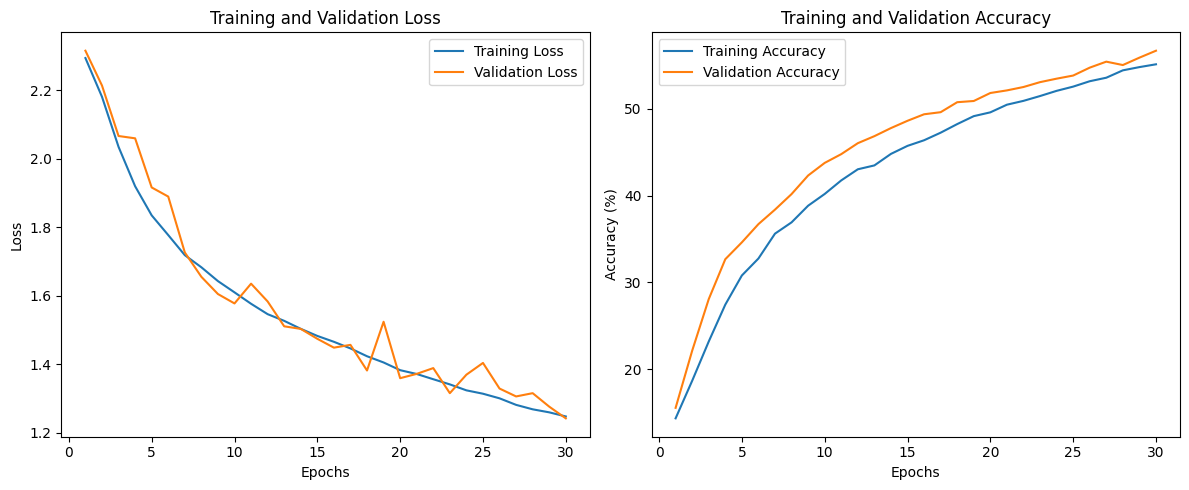

In [29]:

efficientnet_b0 = models.efficientnet_b0(pretrained=False)  
efficientnet_b0.classifier[1] = nn.Linear(efficientnet_b0.classifier[1].in_features, 10)
efficientnet_b0 = efficientnet_b0.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(efficientnet_b0.parameters(), lr=0.001)

ef_net, train_losses_en, val_losses_en, train_accuracies_en, val_accuracies_en = train_and_validate(
    model=efficientnet_b0, 
    trainloader=trainloader, 
    valloader=valloader, 
    loss_fn=loss_fn, 
    optimizer=optimizer, 
    device=device,
    num_epochs=30, patience=5,
)

#Plotting
plot_learning_curves(len(train_accuracies_en), train_accuracies_en, train_losses_en, val_accuracies_en, val_losses_en)

# EfficientNet Finetuning

In [33]:
def grid_search_train_efnet(trainloader, valloader, device, learning_rates, model, num_epochs=20):
    results = []

    for lr in learning_rates:
        
            
            print(f"Training with lr={lr}")

            #Loss_fn and optimizer
            loss_fn = nn.CrossEntropyLoss()
            optimizer = optim.SGD(model.parameters(), lr=lr)

            # Train and validate
            ef_net_trained, train_losses, val_losses, train_accuracies, val_accuracies = train_and_validate_ft(
                model=model,
                trainloader=trainloader,
                valloader=valloader,
                loss_fn=loss_fn,
                optimizer=optimizer,
                device=device,
                num_epochs=num_epochs,
                patience=5,
            )

            #Results
            results.append({
                "learning_rate": lr,
                "train_losses": train_losses,
                "val_losses": val_losses,
                "train_accuracies": train_accuracies,
                "val_accuracies": val_accuracies,
                "model_state_dict": ef_net_trained.state_dict()
            })

            print(f"Finished training with lr={lr}")
            
    return results

In [34]:
torch.save(ef_net.state_dict(), 'ef_net_sgd.pth')

learning_rates = [0.001, 0.01]

#Instance of EfficientNet
efficientnet = models.efficientnet_b0(pretrained=False)

#Modify to match classes
efficientnet.classifier[1] = torch.nn.Linear(efficientnet.classifier[1].in_features, 10)

#Load from saved file
efficientnet.load_state_dict(torch.load('ef_net_sgd.pth'))

efficientnet = efficientnet.to(device)
result_efficent_net = grid_search_train_efnet(trainloader=trainloader, valloader=valloader, device=device, learning_rates=learning_rates, model =efficientnet )


Training with lr=0.001
Epoch [1/20], Train Loss: 1.2382, Train Accuracy: 55.62%, Val Loss: 1.2856, Val Accuracy: 56.65%
Epoch [2/20], Train Loss: 1.2321, Train Accuracy: 55.84%, Val Loss: 1.2404, Val Accuracy: 56.84%
Epoch [3/20], Train Loss: 1.2118, Train Accuracy: 56.53%, Val Loss: 1.2568, Val Accuracy: 57.21%
Epoch [4/20], Train Loss: 1.2062, Train Accuracy: 57.13%, Val Loss: 1.1970, Val Accuracy: 58.02%
Epoch [5/20], Train Loss: 1.1944, Train Accuracy: 57.27%, Val Loss: 1.1906, Val Accuracy: 58.47%
Epoch [6/20], Train Loss: 1.1868, Train Accuracy: 57.51%, Val Loss: 1.2159, Val Accuracy: 58.84%
Epoch [7/20], Train Loss: 1.1755, Train Accuracy: 58.09%, Val Loss: 1.1839, Val Accuracy: 58.92%
Epoch [8/20], Train Loss: 1.1616, Train Accuracy: 58.65%, Val Loss: 1.2089, Val Accuracy: 58.74%
Epoch [9/20], Train Loss: 1.1471, Train Accuracy: 59.12%, Val Loss: 1.1697, Val Accuracy: 59.16%
Epoch [10/20], Train Loss: 1.1430, Train Accuracy: 59.16%, Val Loss: 1.1717, Val Accuracy: 59.28%
Epoch 

Best Configuration Index: 1
Best Configuration:
Learning Rate: 0.01
Final Validation Accuracy: 70.37%


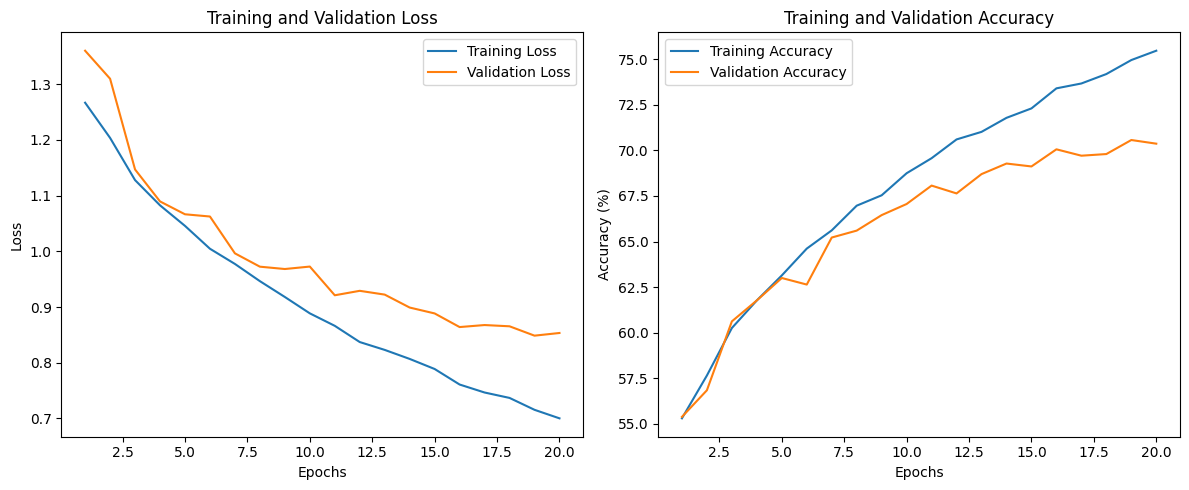

In [35]:
best_index, best_config, best_val_accuracy = find_best_config_index(result_efficent_net)

print(f"Best Configuration Index: {best_index}")
print("Best Configuration:")
print(f"Learning Rate: {best_config['learning_rate']}")
print(f"Final Validation Accuracy: {best_val_accuracy:.2f}%")

#Plotting
plot_learning_curves(len(result_efficent_net[best_index]['train_accuracies']), result_efficent_net[best_index]['train_accuracies'], result_efficent_net[best_index]['train_losses'], result_efficent_net[best_index]['val_accuracies'], result_efficent_net[best_index]['val_losses'])

In [ ]:
efficientnet = models.efficientnet_b0(pretrained=False)

#Modify to match classes
efficientnet.classifier[1] = torch.nn.Linear(efficientnet.classifier[1].in_features, 10)

#Load from saved file
efficientnet.load_state_dict(result_efficent_net[best_index]['model_state_dict'])

efficientnet = efficientnet.to(device)

efficientnet.eval()

#Evaluate test
correct = 0
total = 0

with torch.no_grad():
    for data in testloader: 
        ip, labels = data[0].to(device), data[1].to(device)
        op = efficientnet(ip)
        _, predicted = torch.max(op.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

#Accuracy
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 71.51%
